# Analyse slackline walking from pose data

More at https://safetydave.net/project-slackpose/

# Get data

In [1]:
PROJECT_FOLDER = 'My Drive/slackpose/'
GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + PROJECT_FOLDER

from google.colab import drive
drive.mount(GDRIVE_ROOT)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Read the json output format from openpose

In [2]:
import glob
import json

def build_keypoints_cache(dir):
  dir_list = sorted(glob.glob(dir + '*.json'))
  keypoints_cache = []
  for f in dir_list:
    with open(f) as json_file:
      data = json.load(json_file)
      keypoints_cache.append(data)
  return keypoints_cache

In [3]:
import numpy as np

def single_person_poses(keypoints):
  return np.array([k['people'][0]['pose_keypoints_2d'] for k in keypoints])

Parameters and segment connectivity of Body 25 pose format

In [4]:
KN = 25   # number of keypoints
KS = 3    # step for indexing keypoints
KX = 0    # offset of x coordinate
KY = 1    # offset of y coordinate
KC = 2    # offset of confidence coordinate

In [5]:
B25S = [
  (0,1),                          # neck
  (1,8),                          # spine
  (1,2),(2,3),(3,4),              # right arm
  (1,5),(5,6),(6,7),              # left arm
  (8,9),(9,10),(10,11),           # right pelvis & leg
  (11,24),(11,22),(22,23),        # right foot
  (8,12),(12,13),(13,14),         # left pelvis & leg
  (14,21),(14,19),(19,20),        # left foot
  (0,16),(0,15),(15,17),(16,18)   # eyes & ears
]

Save plots

In [6]:
from pathlib import Path

def put_fig(name, fig_dir=(FS_ROOT + 'fig/')):
  Path(fig_dir).mkdir(parents=True, exist_ok=True)
  plt.savefig(fig_dir + name + '.png')

# Visualise

In [7]:
# buff_2s
# buff_back_4s

keypoints = build_keypoints_cache(FS_ROOT + 'buff_back_4s/')
poses = single_person_poses(keypoints)

In [8]:
len(poses)

215

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

IMG_WIDTH = 383
IMG_HEIGHT = 680
FIG_WIDTH = IMG_WIDTH / 100.0
FIG_HEIGHT = IMG_HEIGHT / 100.0

In [10]:
def plot_points(ax, pose):
  ax.scatter(pose[KX::KS], IMG_HEIGHT - pose[KY::KS], c=range(KN), cmap='hsv')
  ax.set_xlim((0, IMG_WIDTH))
  ax.set_ylim((0, IMG_HEIGHT))

def plot_segments(ax, pose):
  seg_denom = len(B25S) - 1.0
  for i, s in enumerate(B25S):
    a = s[0] * KS
    b = s[1] * KS
    if pose[a + KC] == 0 or pose[b + KC] == 0:
      continue
    xs = [a + KX, b + KX]
    ys = [a + KY, b + KY]
    ax.plot(pose[xs], IMG_HEIGHT - pose[ys], color=mpl.cm.hsv(i / seg_denom), lw=2)
  ax.set_xlim((0, IMG_WIDTH))
  ax.set_ylim((0, IMG_HEIGHT))  

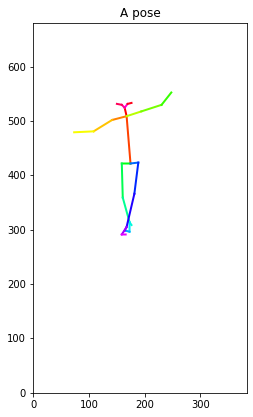

In [11]:
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
plot_segments(plt.gca(), poses[0])
plt.title('A pose')
plt.show()

In [12]:
def kptrace(poses, k):
  kp = [k * KS + KX, k * KS + KY, k * KS + KC]
  return poses[kp] if poses.ndim == 1 else poses[:,kp]

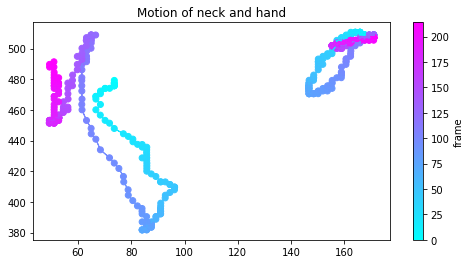

In [13]:
plt.figure(figsize=(8, 4))
def plot_motion(trace):
  plt.scatter(trace[:,KX], IMG_HEIGHT - trace[:,KY], c=range(trace.shape[0]), cmap='cool')
  for p in range(trace.shape[0] - 1):
    x = trace[p, KX]
    dx = trace[p + 1, KX] - x
    y = IMG_HEIGHT - trace[p, KY]
    dy = IMG_HEIGHT - trace[p + 1, KY] - y
    plt.arrow(x, y, dx, dy, color=mpl.cm.cool(p / (poses.shape[0] - 1.0)), width=0.1)

plot_motion(kptrace(poses, 1))
plot_motion(kptrace(poses, 4))
plt.colorbar(label='frame')
plt.title(f'Motion of neck and hand')
plt.show()

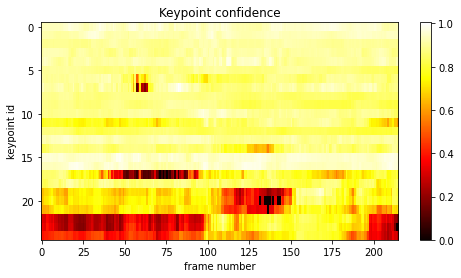

In [14]:
plt.figure(figsize=(8, 4))
plt.imshow(poses[:,KC::KS].T, aspect='auto', interpolation='none', cmap='hot')
plt.colorbar()
plt.title('Keypoint confidence')
plt.xlabel('frame number')
plt.ylabel('keypoint id')
plt.show()

# Deriving Centre of Mass

In [15]:
def point_cog(p, k):
  return kptrace(p, k)

def ratio_cog(p, k1, r1, k2, r2):
  return point_cog(p, k1) * r1 + point_cog(p, k2) * r2

def mid_cog(p, k1, k2):
  return ratio_cog(p, k1, 0.5, k2, 0.5)

Rough guess for centre of mass/gravity (cog) of different parts of the body

In [16]:
def head_cog(p):            return point_cog(p, 0)
def thorax_cog(p):          return ratio_cog(p, 1, 0.8, 8, 0.2)
def abdomen_cog(p):         return ratio_cog(p, 1, 0.33, 8, 0.67)
def pelvis_cog(p):          return point_cog(p, 8)
def upper_arm_right_cog(p): return mid_cog(p, 2, 3)
def lower_arm_right_cog(p): return mid_cog(p, 3, 4)
def hand_right_cog(p):      return point_cog(p, 4)
def upper_arm_left_cog(p):  return mid_cog(p, 5, 6)
def lower_arm_left_cog(p):  return mid_cog(p, 6, 7)
def hand_left_cog(p):       return point_cog(p, 7)
def thigh_right_cog(p):     return mid_cog(p, 9, 10)
def shin_right_cog(p):      return mid_cog(p, 10, 11)
def foot_right_cog(p):      return mid_cog(p, 11, 22)
def thigh_left_cog(p):      return mid_cog(p, 12, 13)
def shin_left_cog(p):       return mid_cog(p, 13, 14)
def foot_left_cog(p):       return mid_cog(p, 14, 19)

Distribution of body mass by part

In [17]:
MASS = {
  'head': (head_cog, 0.0826),
  'thorax': (thorax_cog, 0.2010),
  'abdomen': (abdomen_cog, 0.1310),
  'pelvis': (pelvis_cog, 0.1370),
  'upper_arm_right': (upper_arm_right_cog, 0.0325),
  'lower_arm_right': (lower_arm_right_cog, 0.0187),
  'hand_right': (hand_right_cog, 0.0065),
  'upper_arm_left': (upper_arm_left_cog, 0.0325),
  'lower_arm_left': (lower_arm_left_cog, 0.0187),
  'hand_left': (hand_left_cog, 0.0065),
  'thigh_right': (thigh_right_cog, 0.1050),
  'shin_right': (shin_right_cog, 0.0475),
  'foot_right': (foot_right_cog, 0.0143),
  'thigh_left': (thigh_left_cog, 0.1050),
  'shin_left': (shin_left_cog, 0.0475),
  'foot_left': (foot_left_cog, 0.0143)
}

sum([v[1] for v in MASS.values()])

1.0006

In [18]:
def body_cog(p, cl=0.05):
  contrib = [v[0](p)[[KX, KY]] * v[1] * (v[0](p)[KC] > cl) for v in MASS.values()]
  return sum(contrib)

In [19]:
COG_SIZE = 500

def plot_cog(pose):
  plt.style.use('dark_background')
  plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
  plot_segments(plt.gca(), pose)
  for m in MASS:
    cog = MASS[m][0](pose)
    plt.scatter(cog[KX], IMG_HEIGHT - cog[KY],
                s=COG_SIZE*MASS[m][1], color=mpl.cm.Greys(1.0 - cog[KC]))
  plt.scatter(body_cog(pose)[0], IMG_HEIGHT - body_cog(pose)[1],
              s=COG_SIZE, color='white')

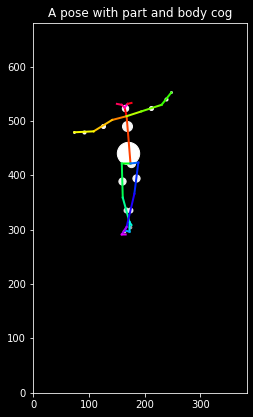

In [20]:
plot_cog(poses[0])
plt.title('A pose with part and body cog')
plt.show()

In [21]:
for i, p in enumerate(poses):
  plot_cog(p)
  put_fig(f'pose_{i:03}')
  plt.close()

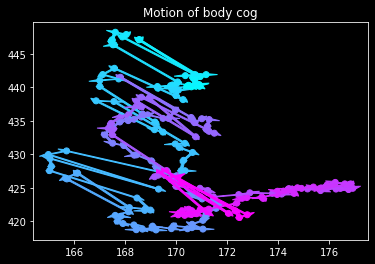

In [22]:
cog_pos = np.apply_along_axis(lambda x: body_cog(x, 0.5), axis=1, arr=poses)

plot_motion(cog_pos)
plt.title('Motion of body cog')
plt.show()